In [1]:
import numpy as np
from sim_handling import Simulation,loadSim, continue_from_surface #uses ds7, both PDEs leads to stable solution
from diffusionstuff7 import f0d,f1d,f2d, getsigmastep_2d
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt

C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [2]:
%matplotlib widget

In [27]:
# Parameters
l = 25
npts = 250#500
midpt = np.round(npts/2).astype(int); print(midpt)
x = np.linspace(-l,l,npts)
N_l = 11
k = N_l/l**2
n = 2
eps = -0.2#05

125


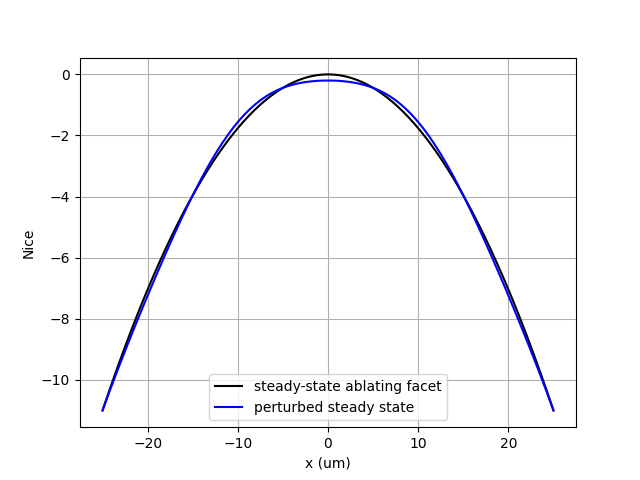

In [28]:
#Perturbation and plot of perturbed estimatd steady state
f_ss = -k*x**2 # Estimated steady state
f_perturbation = eps*np.cos((n+.5)*np.pi*x/l) # Perturbation
f_perturbed = f_ss + f_perturbation
plt.figure()
plt.plot(x,f_ss,'k',label='steady-state ablating facet')
# plt.plot(x,f_perturbation,'r',label='perturbation')
plt.plot(x,f_perturbed,'b',label='perturbed steady state')
plt.grid(True)
plt.xlabel('x (um)')
plt.ylabel('Nice')
plt.legend()

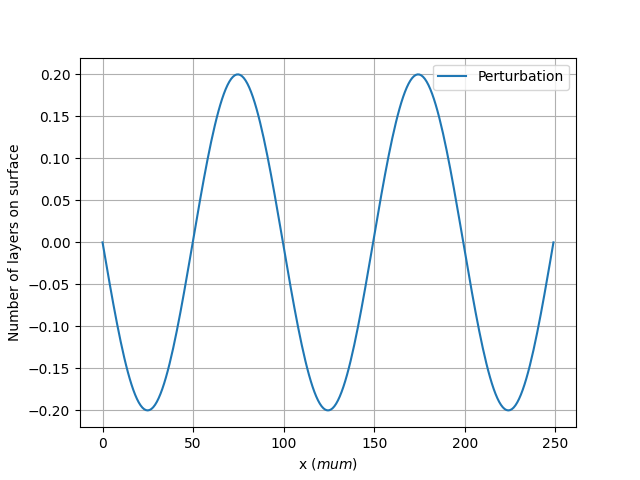

In [29]:
#Perturbation on its own

figname = 'perturbation'
plt.figure(figname)
ax = plt.subplot(111)

ax.set_xlabel(r'x ($mu m$)')
ax.set_ylabel('Number of layers on surface')
ax.plot(f_perturbation, label='Perturbation')
# f_perturbed = ss_1d.results()['y'][-1][1] + f_perturbation
# ax.plot(f_perturbed, label='Perturbed Ice+QLL')
ax.legend()

plt.grid()
plt.show()

In [6]:
plt.close(figname)

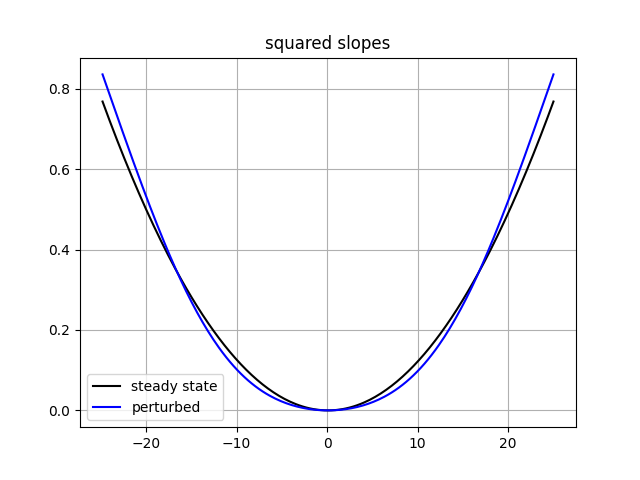

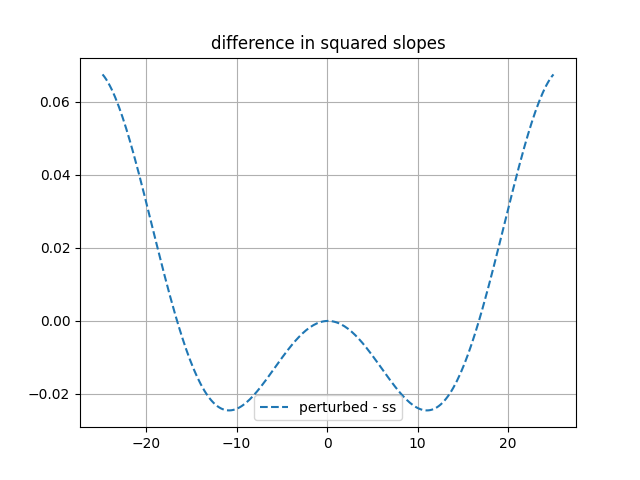

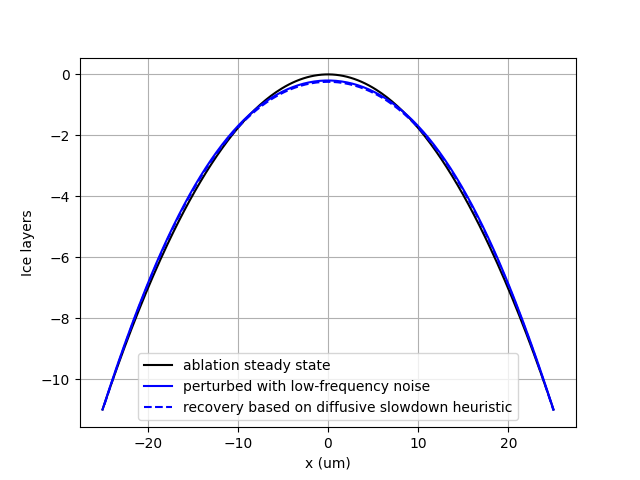

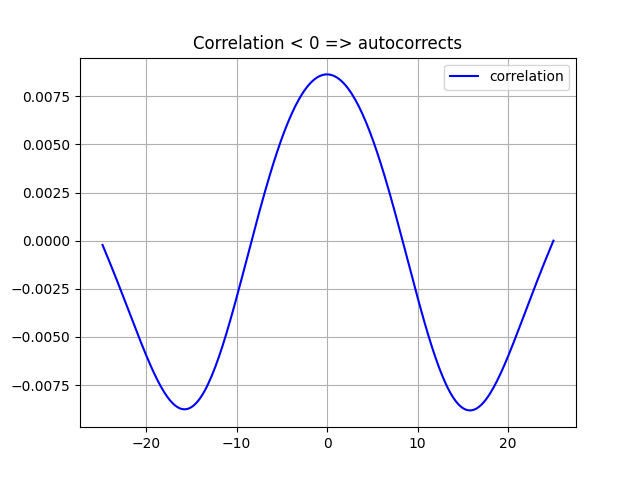

In [7]:
xp = x[1:]

slope_ss_squared = (np.diff(f_ss)/np.diff(x))**2
slope_perturbed_squared = (np.diff(f_perturbed)/np.diff(x))**2
plt.figure()
plt.plot(xp,slope_ss_squared,'k',label='steady state')
plt.plot(xp,slope_perturbed_squared,'b',label='perturbed')
plt.grid(True)
plt.legend()
plt.title('squared slopes')

f2_deviation = slope_perturbed_squared - slope_ss_squared
plt.figure()
plt.plot(xp,f2_deviation,'--',label='perturbed - ss')
plt.grid(True)
plt.legend()
plt.title('difference in squared slopes')

growth_factor = .2
correction = growth_factor*f2_deviation 
f_perturbed_later = f_perturbed[1:] + correction
shift = np.mean(f_ss[1:]-f_perturbed_later)
f_perturbed_later += shift
plt.figure()
plt.plot(x,f_ss,'k',label='ablation steady state')
plt.plot(x,f_perturbed,'b',label='perturbed with low-frequency noise')
plt.plot(xp,f_perturbed_later,'b--',label='recovery based on diffusive slowdown heuristic')
plt.grid(True)
plt.xlabel('x (um)')
plt.ylabel('Ice layers')
plt.legend()

plt.figure()
real_correction = f_perturbed_later - f_perturbed[1:]
plt.plot(xp,f_perturbation[1:]*real_correction,'b',label='correlation')
plt.grid(True)
plt.title('Correlation < 0 => autocorrects')
plt.legend()

In [8]:
#run a 1d sim to get and save the steady state
ss_1d = Simulation(f1d, (250,), method='RK45')
ss_1d.sigmastepmax= 0.20
ss_1d.layermax = 1000

In [9]:
plt.close(0)

breaking because reached max number of layers grown


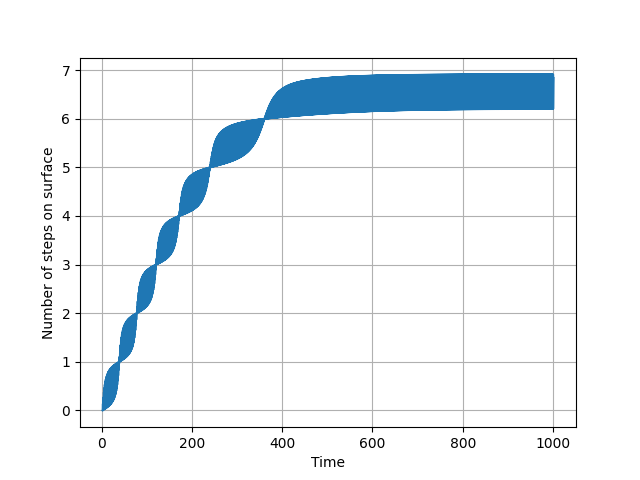

In [10]:
#graph number of steps over time
Ntot = ss_1d.getNtot()
#Ntot = np.load(filename, mmap_mode='r')[:,1,:,:]# if loading resutls from file
Nss_v_time = np.ptp(Ntot, axis=1)

fignum = 0
plt.figure(fignum)
ax = plt.subplot(111)

#ax.plot(test_f2d_sim.results()['t'],maxes-mins)
ax.plot(Ntot[:,0],Nss_v_time)
ax.set_ylabel('Number of steps on surface')
ax.set_xlabel('Time')
plt.grid()
plt.show()

In [11]:
steady_state_ntot = ss_1d.results()['y'][-1][1]
np.save('steady_state_ntot_1000.npy',np.asarray(steady_state_ntot))

In [30]:
print(f_perturbation.shape)

(250,)


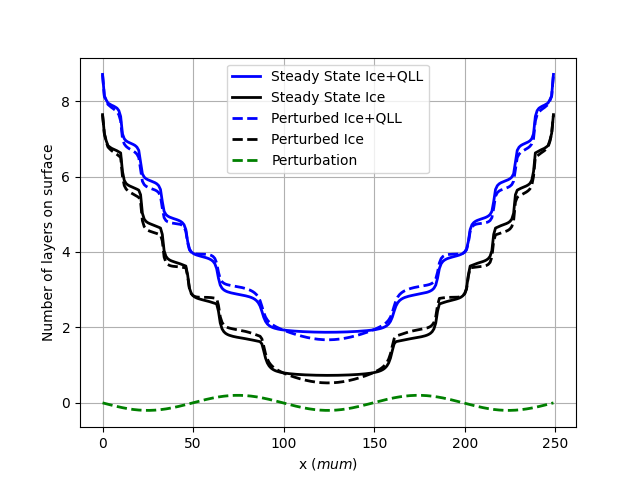

In [38]:
#add the perturbation to the ending surface
ending_fliq,ending_ntot = ss_1d.results()['y'][-1]
fignum = 'perturbation of steady state'
plt.close(fignum)
plt.figure(fignum)
ax = plt.subplot(111)
#ax.plot(test_f2d_sim.results()['t'],maxes-mins)


ax.set_xlabel(r'x ($mu m$)')
ax.set_ylabel('Number of layers on surface')

ntot_perturbed = ss_1d.results()['y'][-1][1] + f_perturbation
fliq_perturbed = ss_1d.results()['y'][-1][0]

offset = np.mean(ntot_perturbed)-4

ax.plot(ending_ntot-offset, label='Steady State Ice+QLL', color='b', linewidth=2)
ax.plot(ending_ntot-ending_fliq-offset, label='Steady State Ice', color='k', linewidth=2)
ax.plot(ntot_perturbed-offset, color='b', label='Perturbed Ice+QLL',linestyle='--', linewidth=2)
ax.plot(ntot_perturbed-fliq_perturbed-offset, color='k', label='Perturbed Ice', linestyle='--', linewidth=2)
ax.plot(f_perturbation, color='g', label='Perturbation', linestyle='--', linewidth=2)
ax.legend()

plt.grid()
plt.show()

In [33]:
plt.close(fignum)

In [ ]:
#run the simulation with the heuristic
#heuristic_1d = Simulation(f1d, (500,), method='RK45')
heuristic_1d = continue_from_surface(ss_1d, ss_1d.results()['y'][-1]+f_perturbation) #copies sim settings and begins from ending surface
heuristic_1d.layermax = 250
heuristic_ntot = heuristic_1d.getNtot()
heuristic_ice = heuristic_1d.getNice()

In [ ]:
#plot the surface over time on subplots

#run the simulation
fig, axs = plt.subplots(2, 4)
for i, cmpltion in enumerate([0,0.01,0.03,0.05,0.1,0.3,0.5,0.8]):
#for i, cmpltion in enumerate([0.1,0.12,0.15, 0.18,0.2,0.23,0.26,0.3]):

    xs = heuristic_ntot[int(cmpltion*heuristic_ntot.shape[0]),:]
    ice = heuristic_ice[int(cmpltion*heuristic_ntot.shape[0]),:]
    axs[i//4, i%4].set_xlabel(r'x ($\mu m$)')
    axs[i//4, i%4].set_ylabel('Layers of ice')
    axs[i//4, i%4].set_ylim(bottom=min(xs)-.5, top=max(xs)+.5)
    axs[i//4, i%4].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs[i//4, i%4].set_title('Completion = '+str(cmpltion*100)+'%')
    axs[i//4, i%4].plot(xs, label='ntot')
    axs[i//4, i%4].plot(ice, label='ice')
plt.legend()
plt.show()

In [ ]:
# plot number of steps over time with heuristic
fignum = 'nss over time starting with heuristic'
plt.close(fignum)

#print(maxes,mins)
plt.figure(fignum)
ax = plt.subplot(111)

#ax.plot(test_f2d_sim.results()['t'],maxes-mins)
ax.plot(heuristic_ntot[:,0],np.ptp(heuristic_ntot, axis=1))
ax.set_ylabel('Number of steps on surface')
ax.set_xlabel('Time')
plt.grid()
plt.show()

In [ ]:
#run the simulations for subplots, setting params
amplitudes = [-0.05,0,0.05]
frequencies = [0,1,2]

list_of_param_pairs = []
for amp in amplitudes:
    for freq in frequencies:
        list_of_param_pairs.append((amp,freq))

In [ ]:
#run the sims and collect ending surfaces
last_step_results = []
nss_results = []
for (amp,freq) in list_of_param_pairs:
    eps = amp
    n = freq
    this_perturbation = eps*np.cos((n+.5)*np.pi*x/l)
    #copy sim settings and begins from ending surface + perturbation
    heur_sim = continue_from_surface(ss_1d, ss_1d.results()['y'][-1]+this_perturbation)
    #run and append
    last_step_results.append(heur_sim.results()['y'][-1])
    nss_results.append(np.ptp(heur_sim.getNtot(), axis=1))

In [ ]:
#save the results
np.save('heuristic_last_step_results.npy', last_step_results)
np.save('heuristic_nss_results.npy', nss_results)

In [ ]:
nss_results = np.load('heuristic_nss_results.npy', allow_pickle=True)

In [ ]:
print(type(nss_results))
print([x.shape for x in nss_results])

In [ ]:
#plot the surface over time on subplots

show_ntot=True
show_ice=True

xlen,ylen =len(amplitudes), len(frequencies)
fig, axs = plt.subplots(xlen,ylen)
for i, (amp,freq) in enumerate(list_of_param_pairs):
    
    # ntot = last_step_results[i][1]
    # ice = last_step_results[i][1]-last_step_results[i][0]
    
    axs[i//xlen, i%ylen].set_xlabel(r'x ($\mu m$)')
    axs[i//xlen, i%ylen].set_ylabel('Layers of ice')

    nss = nss_results[i]
    
    axs[i//xlen, i%ylen].set_ylim(bottom=min(nss)-.5, top=max(nss)+.5)
    
    axs[i//xlen, i%ylen].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs[i//xlen, i%ylen].set_title('Amplitude = '+str(amp)+'+ Frequency ='+str(freq))

    if show_ntot: axs[i//xlen, i%ylen].plot(nss, label='Ice+QLL')

plt.legend()
plt.show()

In [ ]:
#plot the Nss over time on subplots


xlen,ylen =len(amplitudes), len(frequencies)
fig, axs = plt.subplots(xlen,ylen)
for i, (amp,freq) in enumerate(list_of_param_pairs):
    
    ntot = last_step_results[i][1]
    ice = last_step_results[i][1]-last_step_results[i][0]
    
    axs[i//xlen, i%ylen].set_xlabel(r'x ($\mu m$)')
    axs[i//xlen, i%ylen].set_ylabel('Layers of ice')
    axs[i//xlen, i%ylen].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    axs[i//xlen, i%ylen].set_title('Amplitude = '+str(amp)+'+ Frequency ='+str(freq))

    if show_ntot: axs[i//xlen, i%ylen].plot(ntot, label='Ice+QLL')
    if show_ice: axs[i//xlen, i%ylen].plot(ice, label='Ice')

plt.legend()
plt.show()